# Classification of Bottle Openers, Can Openers and Corc Screws by Means of AI Methods

This assignment aims to provide multiple methods for classifying bottle openers, can openers and corc screws from images. The results of the different methods are to be analyzed and compared.

## 1. Data Aquisition and Augmentation

To train the methods for classification from images, first some training data has to be acquired. Many images have been provided in the course. They have been sorted to get only the images suitable for training. Additionally 69 images have been taken.

Data augmentation is useful to get more data. The following kinds of augmentation are applied:
* Horizontal shifts
* Vertical shifts
* Rotations
* Changes in brightness
* Zooming
* Channel shifts
* Added salt-pepper noise
* Added Gaussian noise
* Added speckle noise

They are perfomed multiple times with different parameters. The results are 795438 images total in comparison to 750 original images before the augmentation. The images are saved as numpy arrays in .npy files.

## 2. Feature Extraction

The following features have been extracted from the original image dataset (without the augmented images).
* The outer contour's aspect ratio
* Number of corners detected via Harris Corner Detection
* Number of corners detected via Shi-Tomasi Corner Detection
* The outer contour's perimeter-area ratio

The extracted features are saved in "/data/features.csv".

## 3. Apply AI Methods

A total of five AI methods is to be applied. Three of them are self-implemented from scratch: Naive Bayes Classifier, Decision Tree and Random Forest. Additionally a Convolutional Neural Network (CNN) and a CNN with Transfer Learning using tensorflow and keras have been implemented as well as an additional method which has not been reviewed during the lecture: Support Vector Machines (SVM). 

In [1]:
# Some variables required by multiple methods
predictions = dict()
IMG_SIZE = (32, 32)

# Set "True" for demonstrating the results with the examiner's images
is_presentation = True

### 3.1 Import Data

#### Required Imports

In [2]:
import numpy as np
import pandas as pd
import cv2
import os

import HelperFunctions
import DataAugmentation
import modules.feature_extraction as fe

#### Import Images

In [3]:
if is_presentation:
    testpaths, classes = HelperFunctions.load_images(os.path.join("data", "images", "presentation"))
else:
    testpaths, classes = HelperFunctions.load_images(os.path.join("data", "images", "test"))

X_testdata = []
y_testtdata = []

for path in testpaths:
    img = cv2.imread(path, cv2.COLOR_BGR2RGB)    
    img = DataAugmentation.resizeAndPad(img, IMG_SIZE)
    X_testdata.append(img)
    y_testtdata.append(classes[path.split(os.sep)[-2]])
    
X_testdata = np.array(X_testdata)
y_testdata = np.array(y_testtdata).astype(int)

print(f"Test images: {X_testdata.shape}, test labels: {y_testdata.shape}.")

Test images: (8, 32, 32, 3), test labels: (8,).


#### Import Features

In [4]:
if is_presentation:
    test_features = fe.extract_features(testpaths, classes, display_imgs=True)
    # Drop unnecessary data and put classification column at the end
    test_features = test_features.iloc[:, 2:]
    test_features = test_features.reindex(columns=["Aspect Ratio", "Number of Corners (Harris)", "Number of Corners (Shi-Tomasi)",\
                                         "Perimeter Area Ratio", "Class Index"])
    test_features = test_features.rename(columns={"Aspect Ratio" : 4,
                                                  "Number of Corners (Harris)" : 5,
                                                  "Number of Corners (Shi-Tomasi)" : 6,
                                                  "Perimeter Area Ratio" : 7,
                                                  "Class Index" : 3})
    # Remove the multitool class ???
    test_features = test_features.apply(pd.to_numeric, errors="coerce")
    #     features = features[features.iloc[:, -1] < 3]

    X_test_features = test_features.iloc[:, :-1]
    y_test_features = test_features.iloc[:, -1]

# Read the features CSV file
features = pd.read_csv(r"data\features.csv", sep=';', header=None)
# Drop unnecessary data and put classification column at the end
features = features.iloc[1:, 3:]
features = features.reindex(columns=[4, 5, 6, 7, 3])

# Remove the multitool class ???
features = features.apply(pd.to_numeric, errors="coerce")
#     features = features[features.iloc[:, -1] < 3]

X_features = features.iloc[:, :-1]
y_features = features.iloc[:, -1]

print(X_features.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729 entries, 1 to 729
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   4       729 non-null    float64
 1   5       729 non-null    float64
 2   6       729 non-null    float64
 3   7       729 non-null    float64
dtypes: float64(4)
memory usage: 22.9 KB
None


### 3.2 Naive Bayes Classifier

#### Required Imports

In [5]:
import os
from random import randrange
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

import modules.naive_bayes as nb

#### Prepare Data

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_features, 
                                                    y_features, 
                                                    test_size=0.3, 
                                                    random_state=2)

train = pd.concat([X_train, y_train], axis = 1)

#### Predict With Self-Implemented Method

In [7]:
if is_presentation:
    y_pred = nb.predict(X_test_features, train)
    y_test = y_test_features
else:    
    y_pred = nb.predict(X_test, train)
predictions["Naive Bayes"] = (np.array(y_test).astype(int), np.array(y_pred).astype(int))

#### Predict With sklearn Method

In [8]:
bayes_clf = GaussianNB()
bayes_clf.fit(X_train, y_train)

if is_presentation:
    y_pred = bayes_clf.predict(X_test_features)
    y_test = y_test_features
else:    
    y_pred = bayes_clf.predict(X_test)
predictions["Naive Bayes sklearn"] = (np.array(y_test).astype(int), np.array(y_pred).astype(int))

### 3.2 Decision Tree Classifier

#### Required Imports

In [9]:
import os
import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeClassifier

import DecisionTree as dt

#### Prepare Data

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_features, 
                                                    y_features, 
                                                    test_size=0.2, 
                                                    random_state=42)

train = pd.concat([X_train, y_train], axis=1).to_numpy(dtype='float32')

if is_presentation:
    test = pd.concat([X_test_features, y_test_features], axis=1).to_numpy(dtype='float32')
    y_test = y_test_features
else:
    test = pd.concat([X_test, y_test], axis=1).to_numpy(dtype='float32')

#### Predict With Self-Implemented Method

In [11]:
tree = dt.build_tree(train, 8, 1)
y_pred = [dt.predict(tree, row) for row in test]
predictions["Decision Tree"] = (np.array(y_test).astype(int), np.array(y_pred).astype(int))

#### Predict With sklearn Method

In [12]:
tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train, y_train)

if is_presentation:
    y_pred = tree_clf.predict(X_test_features)
    y_test = y_test_features
else:
    y_pred = tree_clf.predict(X_test)
predictions["Decision Tree sklearn"] = (np.array(y_test).astype(int), np.array(y_pred).astype(int))

### 3.3 Random Forest Classifier

#### Required Imports

In [13]:
import os
import pandas as pd
import numpy as np

import DecisionTree as dt
import RandomForest as rf

from sklearn.ensemble import RandomForestClassifier

#### Prepare Data

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_features, 
                                                    y_features, 
                                                    test_size=0.2, 
                                                    random_state=42)

train = pd.concat([X_train, y_train], axis=1).to_numpy(dtype='float32')
if is_presentation:
    test = pd.concat([X_test_features, y_test_features], axis=1).to_numpy(dtype='float32')
    y_test = y_test_features
else:
    test = pd.concat([X_test, y_test], axis=1).to_numpy(dtype='float32')

#### Predict With Self-Implemented Method

In [15]:
max_depths = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
min_sizes = [3 for i in range(len(max_depths))]
forest = rf.build_forest(train, max_depths, min_sizes)

In [16]:
y_pred = [rf.predict(forest, row) for row in test]
predictions["Random Forest"] = (np.array(y_test).astype(int), np.array(y_pred).astype(int))

#### Predict With sklearn Method

In [17]:
forest_clf = RandomForestClassifier(max_depth=20, random_state=0)
forest_clf.fit(X_train, y_train)
if is_presentation:
    y_pred = forest_clf.predict(X_test_features)
    y_test = y_test_features
else:
    y_pred = forest_clf.predict(X_test)
predictions["Random Forest sklearn"] = (np.array(y_test).astype(int), np.array(y_pred).astype(int))

### 3.4 Convolutional Neural Network

#### Required Imports

In [18]:
from tensorflow.keras import models

#### Predict With Previously Self-Trained Network

In [19]:
# Load previously trained model
model = models.load_model('models/v4')
y_pred = np.argmax(model.predict(X_testdata), axis=1)
predictions["CNN"] = (y_testdata, y_pred)

### 3.5 Transfer Learning With a CNN

#### Required Imports

In [20]:
from tensorflow.keras import models

#### Predict With Previously Adapted and Self-Trained Transfer Learning Network

In [21]:
model = models.load_model('models/tl_v1')
y_pred = np.argmax(model.predict(X_testdata), axis=1)
predictions["CNN Transfer Learning"] = (y_testdata, y_pred)

### 3.6 Support Vector Machine

#### Required Imports

In [22]:
from sklearn.svm import SVC

#### Prepare Data

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_features, 
                                                    y_features, 
                                                    random_state = 21,
                                                    test_size=0.4)

#### Train and Predict

In [24]:
model = SVC(verbose=1, C=1000, gamma=0.002)
model.fit(X_train, y_train)
if is_presentation:
    y_pred = model.predict(X_test_features)
    y_test = y_test_features
else:
    y_pred = model.predict(X_test)
predictions["Support Vector Machine"] = (np.array(y_test).astype(int), np.array(y_pred).astype(int))

[LibSVM]

## 4. Compare Some Scores

In [25]:
import HelperFunctions

In [26]:
for method in predictions:
    print(f"{method}: ")
    print(HelperFunctions.get_scores(predictions[method][0], predictions[method][1]))

-----------------------------------------------
Naive Bayes: 
[0 0 1 1 2 2 3 3] [0 2 2 0 0 0 0 0]
Accuracy:	0.125
Precision:	0.041666666666666664
Recall:		0.125
F1-Score:	0.0625
-----------------------------------------------
Naive Bayes sklearn: 
[0 0 1 1 2 2 3 3] [0 2 2 0 0 0 0 0]
Accuracy:	0.125
Precision:	0.041666666666666664
Recall:		0.125
F1-Score:	0.0625
-----------------------------------------------
Decision Tree: 
[0 0 1 1 2 2 3 3] [3 1 1 1 2 0 1 1]
Accuracy:	0.375
Precision:	0.35
Recall:		0.375
F1-Score:	0.30952380952380953
-----------------------------------------------
Decision Tree sklearn: 
[0 0 1 1 2 2 3 3] [2 3 1 1 2 2 3 3]
Accuracy:	0.75
Precision:	0.5833333333333333
Recall:		0.75
F1-Score:	0.65
-----------------------------------------------
Random Forest: 
[0 0 1 1 2 2 3 3] [2 1 1 1 2 2 1 3]
Accuracy:	0.625
Precision:	0.5416666666666666
Recall:		0.625
F1-Score:	0.5333333333333333
-----------------------------------------------
Random Forest sklearn: 
[0 0 1 1 2 2 3 

D:\Dokumente\python_venvs\ki1_venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Dokumente\python_venvs\ki1_venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Dokumente\python_venvs\ki1_venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Dokumente\python_venvs\ki1_venv\lib\site-packages\sklearn\met

## 5. Demonstrate Results During Presentation

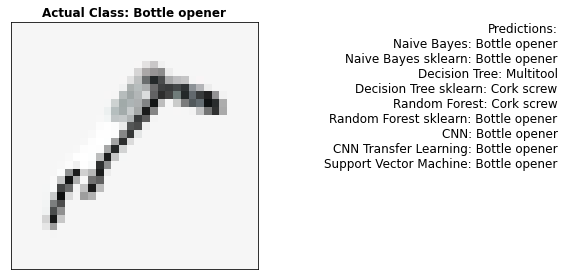

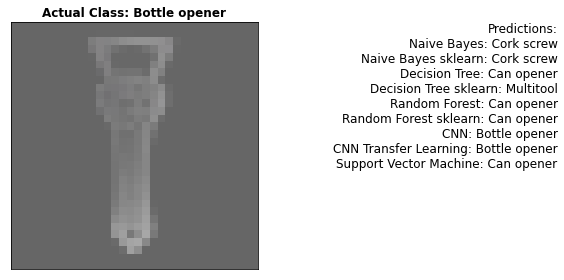

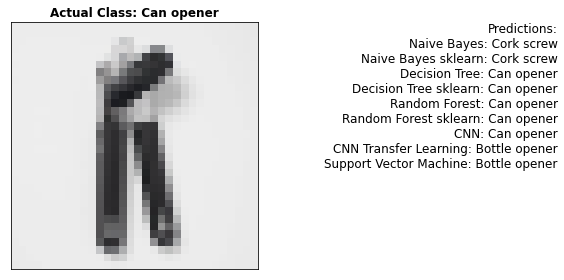

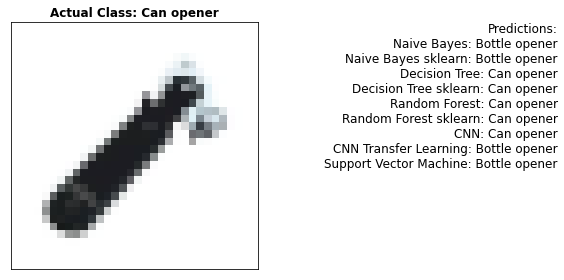

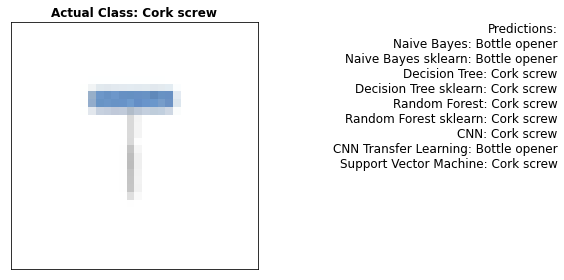

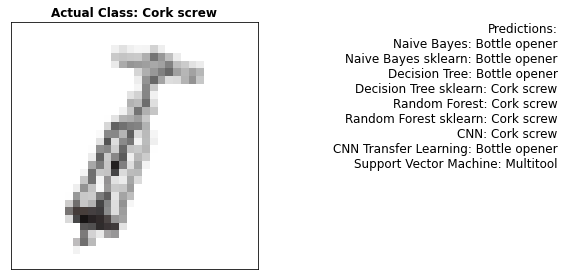

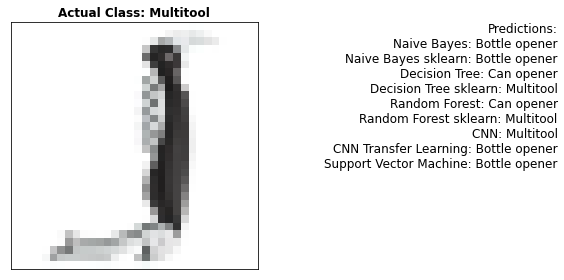

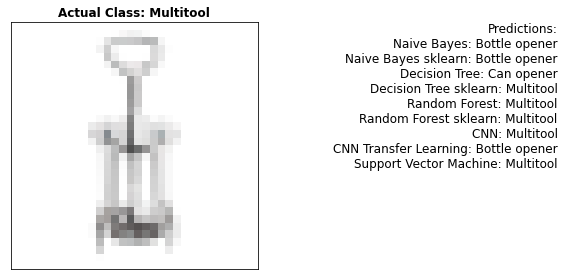

In [67]:
if is_presentation:   
    import matplotlib.pyplot as plt

    class_names = ['Bottle opener', 'Can opener', 'Cork screw', 'Multitool']

    num_imgs = X_testdata.shape[0]

    for i in range(num_imgs):
        pred_str = "Predictions:\n"
        for method in predictions:
            actual = class_names[predictions[method][0][i]]
            predicted = predictions[method][1][i]
            pred_str += f"{method}: {class_names[predicted]}\n"
        
        fig, ax = plt.subplots(1,1,figsize=(4,4))
        ax = plt.subplot(1, 1, 1)
        ax.set_title("Actual Class: " + actual, fontweight="bold")
        ax.yaxis.set_label_position("right")
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(X_testdata[i])
        plt.tight_layout()
        plt.ylabel(pred_str, 
                   rotation=0,
                   labelpad=300,
                   loc='top',
                   fontsize=12) 
        